# Librerías

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from matplotlib.dates import DateFormatter

In [9]:
def plot_data(data, columns: list, title):
    
    fig_1, ax_1 = plt.subplots(figsize=(14, 7))
    plt.style.use('_mpl-gallery')
    
    ax_1.xaxis.set_major_locator(MonthLocator(interval=1))
    ax_1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax_1.yaxis.grid(True, zorder=0)
    
    ax_1.set_title(title)
    ax_1.set_xlabel('Fecha')
    ax_1.set_ylabel('Evapotranspiración de referencia $mm día^{-1}$')
    
    ax_1.plot(data[columns[0]], data[columns[1]], linewidth=1, color='b')
    ax_1.scatter(data[columns[0]], data[columns[1]], color='red')
    
    
    plt.xticks(rotation=90)
    plt.show()

In [23]:
df = pd.read_csv(r"C:\Users\DELL\PycharmProjects\Tesis\dataframes\merged\parcela_11.csv")
df['Fecha'] = df['Fecha'].astype('datetime64[ns]')

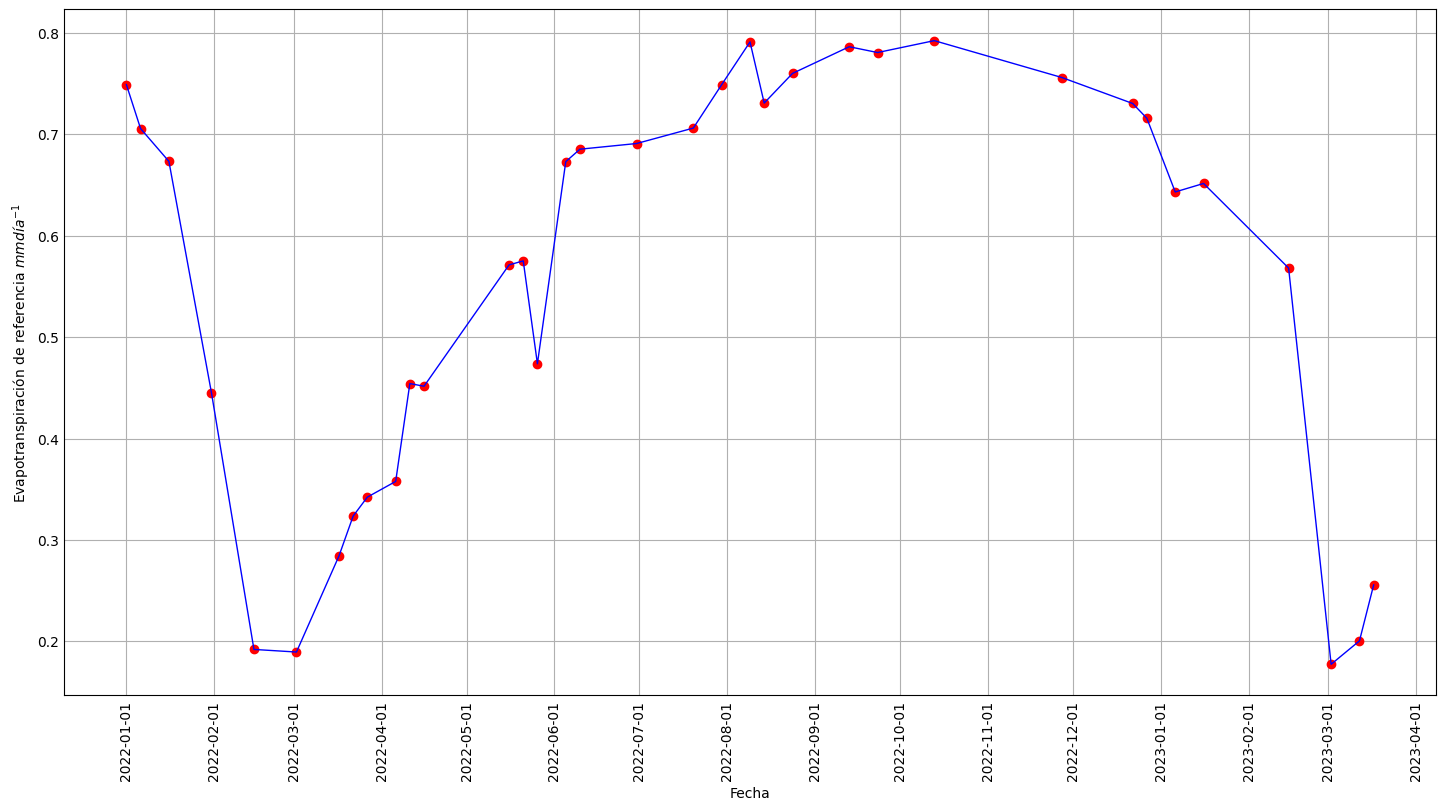

In [24]:
plot_data(df, columns=['Fecha', 'mean'], title='')